# Facial Expression Recognition Project

## Library Installations and Imports

In [2]:
!pip install -U -q PyDrive
!apt-get -qq install -y graphviz && pip install -q pydot
!pip install -q keras


from google.colab import files

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import pydot

import tensorflow as tf
from tensorflow.python.client import device_lib

from keras.models import Sequential
from keras.layers import Conv2D, LocallyConnected2D, MaxPooling2D, Dense
from keras.layers import Activation, Dropout, Flatten
from keras.callbacks import EarlyStopping
from keras.utils import plot_model, to_categorical
from keras import backend as K


Selecting previously unselected package fontconfig.
(Reading database ... 16712 files and directories currently installed.)
Preparing to unpack .../00-fontconfig_2.11.94-0ubuntu2_amd64.deb ...
Unpacking fontconfig (2.11.94-0ubuntu2) ...
Selecting previously unselected package libjbig0:amd64.
Preparing to unpack .../01-libjbig0_2.1-3.1_amd64.deb ...
Unpacking libjbig0:amd64 (2.1-3.1) ...
Selecting previously unselected package libcdt5.
Preparing to unpack .../02-libcdt5_2.38.0-16ubuntu2_amd64.deb ...
Unpacking libcdt5 (2.38.0-16ubuntu2) ...
Selecting previously unselected package libcgraph6.
Preparing to unpack .../03-libcgraph6_2.38.0-16ubuntu2_amd64.deb ...
Unpacking libcgraph6 (2.38.0-16ubuntu2) ...
Selecting previously unselected package libtiff5:amd64.
Preparing to unpack .../04-libtiff5_4.0.8-5_amd64.deb ...
Unpacking libtiff5:amd64 (4.0.8-5) ...
Selecting previously unselected package libwebp6:amd64.
Preparing to unpack .../05-libwebp6_0.6.0-3_amd64.deb ...
Unpacking libwebp6:amd

Setting up libxcb-shm0:amd64 (1.12-1ubuntu1) ...
Setting up libxpm4:amd64 (1:3.5.12-1) ...
Setting up libxt6:amd64 (1:1.1.5-1) ...
Setting up libthai-data (0.1.26-3) ...
Setting up libcdt5 (2.38.0-16ubuntu2) ...
Setting up fontconfig (2.11.94-0ubuntu2) ...
Regenerating fonts cache... done.
Setting up libcgraph6 (2.38.0-16ubuntu2) ...
Setting up libwebp6:amd64 (0.6.0-3) ...
Setting up libcairo2:amd64 (1.14.10-1ubuntu1) ...
Setting up libgvpr2 (2.38.0-16ubuntu2) ...
Setting up libgd3:amd64 (2.2.5-3) ...
Setting up libharfbuzz0b:amd64 (1.4.2-1) ...
Setting up libthai0:amd64 (0.1.26-3) ...
Setting up libxmu6:amd64 (2:1.1.2-2) ...
Setting up libpango-1.0-0:amd64 (1.40.12-1) ...
Setting up libxaw7:amd64 (2:1.0.13-1) ...
Setting up libpangoft2-1.0-0:amd64 (1.40.12-1) ...
Setting up libpangocairo-1.0-0:amd64 (1.40.12-1) ...
Setting up libgvc6 (2.38.0-16ubuntu2) ...
Setting up graphviz (2.38.0-16ubuntu2) ...
Processing triggers for libc-bin (2.26-0ubuntu2.1) ...


Using TensorFlow backend.


### Confirm Tensorflow and GPU Support

In [3]:
K.tensorflow_backend._get_available_gpus()

['/job:localhost/replica:0/task:0/device:GPU:0']

In [4]:
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 18420466127784611552, name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 356122624
 locality {
   bus_id: 1
 }
 incarnation: 6601253422823443615
 physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:04.0, compute capability: 3.7"]

In [5]:
tf.test.gpu_device_name()

'/device:GPU:0'

## Helper Functions

In [0]:
def uploadFiles():
  uploaded = files.upload()

  for fn in uploaded.keys():
    print('User uploaded file "{name}" with length {length} bytes'.format(
        name=fn, length=len(uploaded[fn])))
    
  filenames = list(uploaded.keys())
  for f in filenames:
    data = str(uploaded[f], 'utf-8')
    file = open(f, 'w')
    file.write(data)
    file.close()

def pullImage(frame, index: int):
  """
  Takes in a pandas data frame object and an index and returns the 48 x 48 pixel
  matrix as well as the label for the type of emotion.
  """
  img = frame.loc[index]['pixels'].split(' ')
  img = np.array([np.int(i) for i in img])
  img.resize(48,48)
  label = np.uint8(frame.loc[index]['emotion'])
  
  return img, label

def splitImage_Labels(frame):
  """
  Takes in a pandas data frame object filled with pixel field and label field 
  and returns two numpy arrays; one for images and one for labels.
  """
  labels = np.empty(len(frame))
  images = np.empty((len(frame), 48, 48, 1))  # using channel last notation.
  
  for i in range(len(frame)):
    img, lbl = pullImage(frame, i)
    img = np.reshape(img, (48,48,1))
    images[i], labels[i] = img, lbl
    
  return images.astype(np.uint8), to_categorical(labels, 7).astype(np.uint8)

## Import FER2013 Dataset and Other Files

In [0]:
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# previous token was 4/AACID65Nxa7BHDHpZA-B8KTFCD_ctqRXJjozgUjW5rirIQVTFwJzE3E

In [0]:
fer2013 = drive.CreateFile({'id':'1Xdlvej7eXaVcfCf3CsQ1LcSFAiNx_63c'})

In [0]:
fer2013.GetContentFile('fer2013file.csv')

Save file as a pandas dataframe.

In [0]:
df = pd.read_csv('fer2013file.csv')

## Parse Data

Each image is a 48 x 48 grayscale photo.

The contents of pixel string are space-separated pixel values in row major order.

Emotional assignment convention:


*   0 = Angry
*   1 = Disgust
*   2 = Fear
*   3 = Happy
*   4 = Sad
*   5 = Surprise
*   6 = Neutral


In [0]:
df_Training = df[df.Usage == 'Training']
df_Testing = df[df.Usage == 'PrivateTest'].reset_index(drop = True)
img_train, lbl_train = splitImage_Labels(df_Training)
img_test, lbl_test = splitImage_Labels(df_Testing)

In [12]:
print('Type and Shape of Image Datasets: ' + '\n\tTraining: ' + '\t' + 
      str(type(img_train[0][0][0][0])) + '\t' + str(img_train.shape) + 
      '\n\tTesting: ' + '\t' + str(type(img_train[0][0][0][0])) + '\t' + 
      str(img_test.shape))
print('Type and Shape of Image Datasets: ' + '\n\tTraining: ' + '\t' + 
      str(type(lbl_train[0][0])) + '\t' + str(lbl_train.shape) + 
      '\n\tTesting: ' + '\t' + str(type(lbl_train[0][0])) + '\t' + 
      str(lbl_test.shape))

Type and Shape of Image Datasets: 
	Training: 	<class 'numpy.uint8'>	(28709, 48, 48, 1)
	Testing: 	<class 'numpy.uint8'>	(3589, 48, 48, 1)
Type and Shape of Image Datasets: 
	Training: 	<class 'numpy.uint8'>	(28709, 7)
	Testing: 	<class 'numpy.uint8'>	(3589, 7)


### Save Data to .npy Files

In [0]:
np.save('img_train.npy', img_train)
np.save('lbl_train.npy', lbl_train)
np.save('img_test.npy', img_test)
np.save('lbl_test.npy', img_test)

### Verify Image Import

Text(0.5,1,'Training Image 1 (with label [1 0 0 0 0 0 0])')

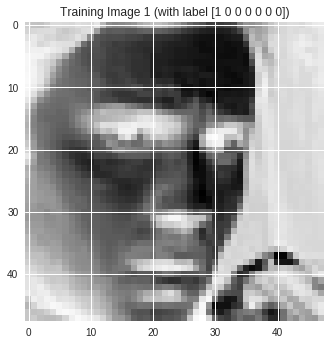

In [13]:
plt.imshow(np.reshape(img_train[0], (48,48)))
plt.title('Training Image 1 (with label ' + str(lbl_train[0]) + ')')

Text(0.5,1,'Training Image 1 (with label [1 0 0 0 0 0 0])')

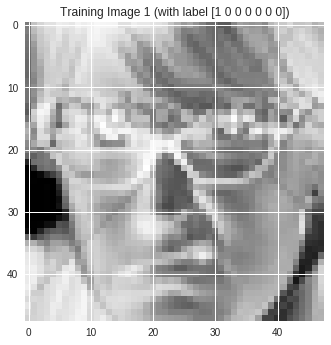

In [14]:
plt.imshow(np.reshape(img_test[0], (48,48)))
plt.title('Training Image 1 (with label ' + str(lbl_test[0]) + ')')

## Build Convolutional Neural Network Model


In [0]:
model = Sequential()

### Level 1
- Size of Convolutional Template Filter: 3 x 3 pixels
- Size of Template Stride: 3 pixels (for both horizontal and vertical stride)
- Number of output filters in the convolution: 32
- Padding protocol: Output is same dimensions as original image.

In [16]:
filterSize = 32
kernelSize = 3
strideSize = 1

model.add(Conv2D(filterSize, kernelSize, strides = strideSize, padding='same', 
                 activation='relu', input_shape=img_train[0].shape))
model.add(Conv2D(filterSize, kernelSize, strides = strideSize, padding='same', 
                 activation='relu'))
model.add(Conv2D(filterSize, kernelSize, strides = strideSize, padding='same', 
                 activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 48, 48, 32)        320       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 48, 48, 32)        9248      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 48, 48, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 24, 24, 32)        0         
Total params: 18,816
Trainable params: 18,816
Non-trainable params: 0
_________________________________________________________________


### Level 2

- Size of Convolutional Template Filter: 3 x 3 pixels
- Size of Template Stride: 3 pixels (for both horizontal and vertical stride)
- Number of output filters in the convolution: 64
- Padding protocol: Output is same dimensions as original image.

In [17]:
filterSize = 64
kernelSize = 3 
strideSize = 1

model.add(Conv2D(filterSize, kernelSize, strides = strideSize, padding='same', 
                 activation='relu'))
model.add(Conv2D(filterSize, kernelSize, strides = strideSize, padding='same', 
                 activation='relu'))
model.add(Conv2D(filterSize, kernelSize, strides = strideSize, padding='same', 
                 activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 48, 48, 32)        320       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 48, 48, 32)        9248      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 48, 48, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 24, 24, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 24, 24, 64)        18496     
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 24, 24, 64)        36928     
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 24, 24, 64)        36928     
__________

### Level 3

- Size of Convolutional Template Filter: 3 x 3 pixels
- Size of Template Stride: 3 pixels (for both horizontal and vertical stride)
- Number of output filters in the convolution: 128
- Padding protocol: Output is same dimensions as original image.

In [18]:
filterSize = 128
kernelSize = 3
strideSize = 1

model.add(Conv2D(filterSize, kernelSize, strides = strideSize, padding='same', 
                 activation='relu'))
model.add(Conv2D(filterSize, kernelSize, strides = strideSize, padding='same', 
                 activation='relu'))
model.add(Conv2D(filterSize, kernelSize, strides = strideSize, padding='same', 
                 activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 48, 48, 32)        320       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 48, 48, 32)        9248      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 48, 48, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 24, 24, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 24, 24, 64)        18496     
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 24, 24, 64)        36928     
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 24, 24, 64)        36928     
__________

### Dense Layers

In [19]:
layerSize = 64
dropoutRate = 0.5

model.add(Flatten())
model.add(Dense(layerSize, activation='relu'))
model.add(Dropout(dropoutRate))
model.add(Dense(layerSize, activation='relu'))
model.add(Dropout(dropoutRate))
model.add(Dense(7, activation='softmax'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 48, 48, 32)        320       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 48, 48, 32)        9248      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 48, 48, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 24, 24, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 24, 24, 64)        18496     
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 24, 24, 64)        36928     
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 24, 24, 64)        36928     
__________

### Show Model Structure

In [0]:
plot_model(model, to_file='model.png', show_shapes=True)

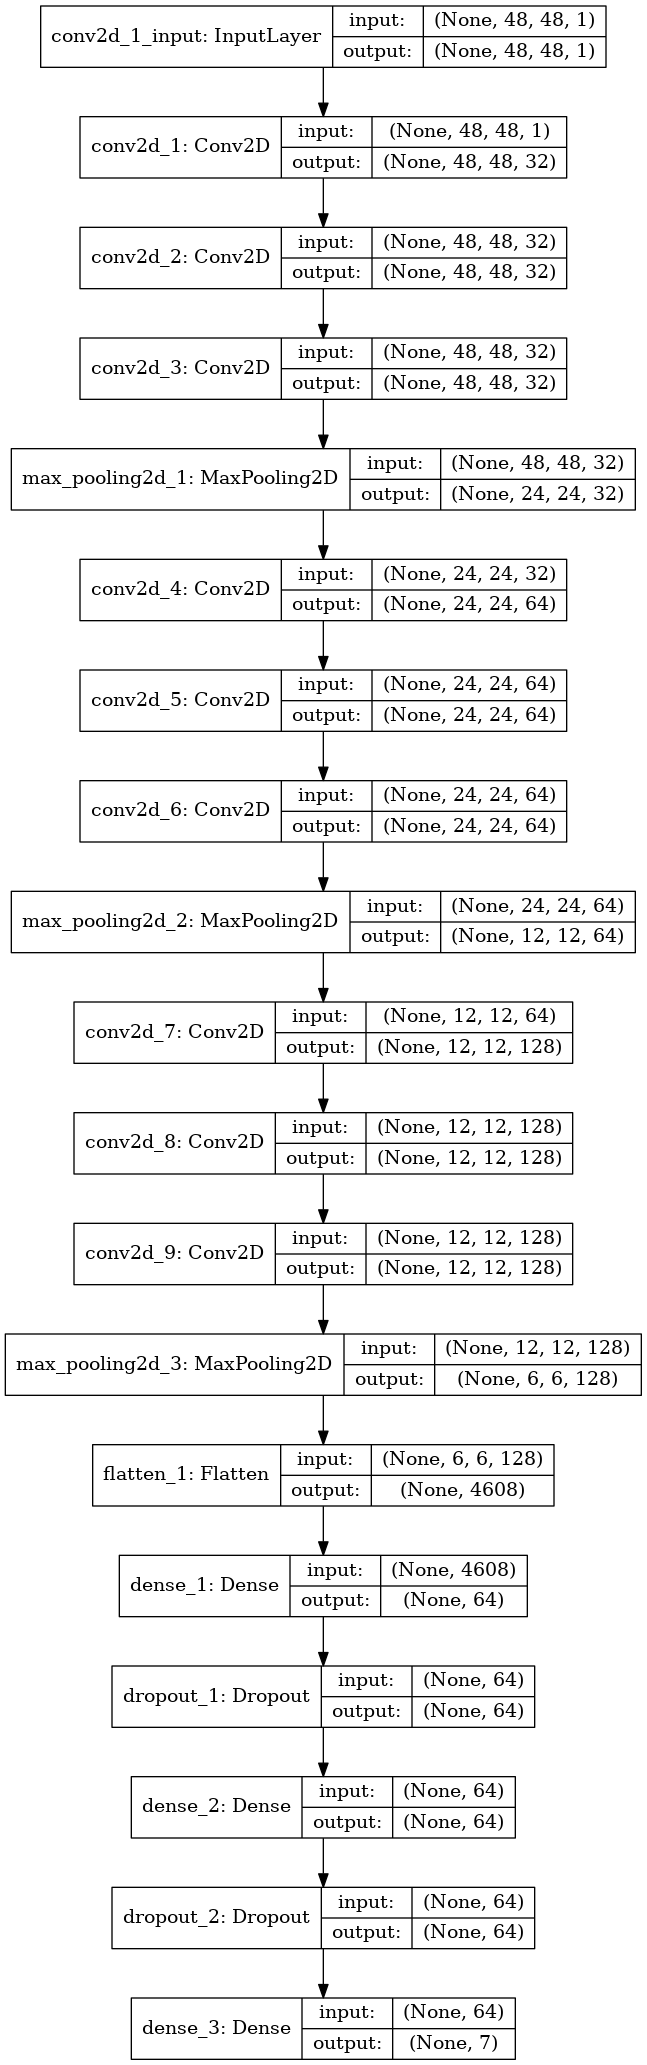

In [25]:
from IPython.display import Image
Image(filename='model.png') 

## Compile, Train, and Evaluate the Model

In [26]:
batchSize = 128
trainingEpochs = 50

model.compile(optimizer='adam', loss='categorical_crossentropy',
              metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1)

trainingHistory = model.fit(img_train, lbl_train, batch_size=batchSize, 
                            epochs=trainingEpochs,validation_split=0.3, 
                            callbacks=[early_stopping], shuffle=True,)

trainingAccuracy = trainingHistory.history['acc']
validationAccuracy = trainingHistory.history['val_acc']
print("Done Training: ")
print('Final Training Accuracy: ', trainingAccuracy[-1])
print('Final Validation Accuracy: ', validationAccuracy[-1])
print('Overfit Ratio: ', validationAccuracy[-1]/trainingAccuracy[-1])

metrics = model.evaluate(img_test, lbl_test, batch_size=batchSize, verbose=1)
print('Evaluation Loss: ', metrics[0])
print('Evaluation Accuracy: ', metrics[1])

Train on 20096 samples, validate on 8613 samples
Epoch 1/50
20096/20096 [==============================] - 23s 1ms/step - loss: 1.8761 - acc: 0.2260 - val_loss: 1.8190 - val_acc: 0.2529
Epoch 2/50
20096/20096 [==============================] - 22s 1ms/step - loss: 1.8227 - acc: 0.2447 - val_loss: 1.7787 - val_acc: 0.2529
Epoch 3/50
10112/20096 [==============>...............] - ETA: 9s - loss: 1.7924 - acc: 0.2486

20096/20096 [==============================] - 22s 1ms/step - loss: 1.7714 - acc: 0.2578 - val_loss: 1.6610 - val_acc: 0.3185
Epoch 4/50
20096/20096 [==============================] - 22s 1ms/step - loss: 1.6864 - acc: 0.3100 - val_loss: 1.5722 - val_acc: 0.3804
Epoch 5/50
20096/20096 [==============================] - 22s 1ms/step - loss: 1.6091 - acc: 0.3487 - val_loss: 1.4991 - val_acc: 0.4050
Epoch 6/50
  640/20096 [..............................] - ETA: 18s - loss: 1.5928 - acc: 0.3984

20096/20096 [==============================] - 22s 1ms/step - loss: 1.5490 - acc: 0.3783 - val_loss: 1.4565 - val_acc: 0.4205
Epoch 7/50
20096/20096 [==============================] - 22s 1ms/step - loss: 1.5059 - acc: 0.3968 - val_loss: 1.4181 - val_acc: 0.4400
Epoch 8/50
18688/20096 [==========================>...] - ETA: 1s - loss: 1.4564 - acc: 0.4150

20096/20096 [==============================] - 22s 1ms/step - loss: 1.4536 - acc: 0.4159 - val_loss: 1.4035 - val_acc: 0.4509
Epoch 9/50
20096/20096 [==============================] - 22s 1ms/step - loss: 1.4226 - acc: 0.4268 - val_loss: 1.3724 - val_acc: 0.4415
Epoch 10/50
20096/20096 [==============================] - 22s 1ms/step - loss: 1.3814 - acc: 0.4417 - val_loss: 1.3305 - val_acc: 0.4700
Epoch 11/50
 2048/20096 [==>...........................] - ETA: 17s - loss: 1.3359 - acc: 0.4624

20096/20096 [==============================] - 22s 1ms/step - loss: 1.3537 - acc: 0.4570 - val_loss: 1.3259 - val_acc: 0.4796
Epoch 12/50
20096/20096 [==============================] - 22s 1ms/step - loss: 1.3229 - acc: 0.4703 - val_loss: 1.3279 - val_acc: 0.4939
Epoch 13/50
18944/20096 [===========================>..] - ETA: 1s - loss: 1.2935 - acc: 0.4795

20096/20096 [==============================] - 22s 1ms/step - loss: 1.2960 - acc: 0.4792 - val_loss: 1.3197 - val_acc: 0.4896
Epoch 14/50
20096/20096 [==============================] - 22s 1ms/step - loss: 1.2655 - acc: 0.4918 - val_loss: 1.3155 - val_acc: 0.5016
Epoch 15/50
20096/20096 [==============================] - 22s 1ms/step - loss: 1.2507 - acc: 0.4948 - val_loss: 1.3011 - val_acc: 0.5098
Epoch 16/50
 1920/20096 [=>............................] - ETA: 17s - loss: 1.2333 - acc: 0.4979

20096/20096 [==============================] - 22s 1ms/step - loss: 1.2332 - acc: 0.5040 - val_loss: 1.2806 - val_acc: 0.5149
Epoch 17/50
20096/20096 [==============================] - 22s 1ms/step - loss: 1.1939 - acc: 0.5245 - val_loss: 1.2813 - val_acc: 0.5197
Epoch 18/50
18944/20096 [===========================>..] - ETA: 1s - loss: 1.1798 - acc: 0.5282

20096/20096 [==============================] - 22s 1ms/step - loss: 1.1770 - acc: 0.5293 - val_loss: 1.2964 - val_acc: 0.5155
Epoch 19/50
20096/20096 [==============================] - 22s 1ms/step - loss: 1.1511 - acc: 0.5387 - val_loss: 1.2723 - val_acc: 0.5272
Epoch 20/50
20096/20096 [==============================] - 22s 1ms/step - loss: 1.1359 - acc: 0.5509 - val_loss: 1.3077 - val_acc: 0.5135
Epoch 21/50
 1920/20096 [=>............................] - ETA: 17s - loss: 1.1214 - acc: 0.5453

20096/20096 [==============================] - 22s 1ms/step - loss: 1.1008 - acc: 0.5634 - val_loss: 1.2926 - val_acc: 0.5198
Epoch 22/50
20096/20096 [==============================] - 22s 1ms/step - loss: 1.0966 - acc: 0.5674 - val_loss: 1.3435 - val_acc: 0.5175
Epoch 23/50
18944/20096 [===========================>..] - ETA: 1s - loss: 1.0619 - acc: 0.5807

20096/20096 [==============================] - 22s 1ms/step - loss: 1.0628 - acc: 0.5806 - val_loss: 1.2953 - val_acc: 0.5376
Epoch 24/50
20096/20096 [==============================] - 22s 1ms/step - loss: 1.0432 - acc: 0.5879 - val_loss: 1.2934 - val_acc: 0.5344
Epoch 00024: early stopping
Done Training: 
Final Training Accuracy:  0.5879279458598726
Final Validation Accuracy:  0.5344247068038984
Overfit Ratio:  0.9089969452332749
3589/3589 [==============================] - 1s 302us/step
Evaluation Loss:  1.320550417993088
Evaluation Accuracy:  0.506826414076124
